---
# SC4002 Natural Language Processing Group Project

Group Members:
1. Asher Lim Guojun (U2220846H)
2. Celeste Ang Jianing (U2222319H)
3. Koh Jia Hui Rachel (U2222747H)
4. Lim Kiat Sen, Jaron (U2222010K)
5. Pang Boslyn (U2221298A)

---
## Setup & Libraries

Dev notes: I directly installed the model en_core_web_sm 3.7.1 via 'uv add'.

In [48]:
from torchtext import data, datasets
import torch
import spacy
import random
import numpy as np

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(0)

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from itertools import product
import pandas as pd

In [49]:
# Load SpaCy
nlp = spacy.load("en_core_web_sm")

 # For tokenization
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm',include_lengths = True, pad_token='<pad>')
# For multi - class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data , test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained = False)
# Split train into train/valid (80/20)
train_data, valid_data = train_data.split(
    split_ratio=0.8,
    random_state=random.seed(42)  # <-- use random.seed here
)

print(f"Train examples: {len(train_data)}")
print(f"Validation examples: {len(valid_data)}")

Train examples: 4362
Validation examples: 1090


In [50]:
print(vars(train_data.examples[0]))

{'text': ['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?'], 'label': 'ENTY'}


Let's use Glove model for word embeddings.     
(Start with GloVe 6B.100d or 6B.300d as it provides a good balance between coverage and performance for TREC's question classification task. If results are underwhelming, experiment with word2vec Google News vectors as an alternative, but empirical results in the literature suggest GloVe performs comparably or slightly better on this specific dataset.)

In [51]:
from torchtext.vocab import GloVe, Vectors
glove = GloVe(name='6B', dim=300)

# Option 1: Use built-in GloVe (torchtext will download automatically)
TEXT.build_vocab(train_data, vectors=glove)

In [52]:
LABEL.build_vocab(train_data)

---
## Qn 1: Word Embeddings
**a) What is the size of the vocabulary formed from your training data according to your tokenization method?**

In [53]:
# Preprocess the training dataset
train_tokens = [example.text for example in train_data.examples]

# Print the first 5 preprocessed sentences
print("First 5 Tokens:", train_tokens[:5])

First 5 Tokens: [['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?'], ['Where', 'are', 'the', 'leading', 'medical', 'groups', 'specializing', 'in', 'lung', 'diseases', '?'], ['What', 'actor', 'said', 'in', 'A', 'Day', 'at', 'the', 'Races', ':', '`', '`', 'Either', 'he', "'s", 'dead', 'or', 'my', 'watch', 'has', 'stopped', "''", '?'], ['Which', 'area', 'produces', 'the', 'least', 'acidic', 'coffee', '?'], ['When', 'did', 'Princess', 'Diana', 'and', 'Prince', 'Charles', 'get', 'married', '?']]


In [54]:
from collections import Counter
# Iterate through the train dataset tokens and get the unique words to build vocabulary
vocab_counter = Counter([word for tokens in train_tokens for word in tokens])
print(vocab_counter)
train_vocab = list(vocab_counter.keys())
print(train_vocab)
# Get the size of the vocabulary
vocab_size = len(train_vocab)

# Answer to 1(a)
print("Vocabulary Size:", vocab_size)

Counter({'?': 4280, 'the': 2883, 'What': 2562, 'is': 1350, 'of': 1231, 'in': 913, 'a': 807, '`': 691, 'How': 622, "'s": 588, 'was': 529, 'to': 460, ',': 456, 'Who': 453, 'are': 363, 'for': 362, 'and': 360, "''": 330, 'did': 312, 'does': 312, '-': 293, 'many': 268, 'do': 263, 'on': 244, 'Where': 226, 'name': 206, 'first': 163, 'I': 160, 'you': 147, 'can': 140, 'The': 132, 'that': 122, 'from': 120, 'When': 111, 'what': 110, 'by': 107, 'with': 107, 'U.S.': 107, 'most': 106, 'world': 102, 'as': 99, 'have': 97, 'country': 97, '.': 96, 'an': 94, 'has': 89, 'Which': 84, 'city': 84, "'": 81, 'there': 79, 'Why': 78, 'Name': 76, 'it': 74, 'people': 71, 'were': 71, 'be': 71, 'find': 69, 'his': 67, 'year': 67, 'made': 64, 'at': 63, 'largest': 63, 'called': 62, 'get': 61, 'American': 60, 'fear': 60, 'In': 60, 'two': 58, 'much': 57, 'mean': 56, 'state': 56, 'its': 51, 'between': 49, 'long': 48, ':': 47, 'who': 47, 'used': 47, 'origin': 47, 'company': 44, 'word': 43, 'about': 43, 'famous': 42, 'known

Using glove model, we attain a vocabulary of size 8091.

**b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but
not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?
What is the number of OOV words for each topic category?**

OOV words: words in training data that are not found in the glove model's dictionary.

In [55]:
import torchtext
from collections import defaultdict, Counter
# Get only the GloVe vocab (words with pretrained vectors)
glove_vocab = set(glove.stoi.keys())

oov_words_by_topic = defaultdict(Counter)

for example in train_data.examples:
    label = example.label
    tokens = example.text
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower().strip()
        if token_lower not in glove_vocab:
            oov_words_by_topic[label][token_lower] += 1

total_oov_words = set()
for counter in oov_words_by_topic.values():
    total_oov_words.update(counter.keys())

total_count = sum(
    count
    for counter in oov_words_by_topic.values()
    for count in counter.values()
)
print(f"Total count of all OOV word occurrences: {total_count}")
print(f"Total number of OOV words in training data: {len(total_oov_words)}")
print("Number of OOV words per topic category:")

for topic, counter in oov_words_by_topic.items():
    print(f"Topic {topic}: {len(counter)} unique OOV words")
    print("Total occurrence of OOV words: ", sum(counter.values()))
    print("-"*50)
    print(counter.most_common(10))

Total count of all OOV word occurrences: 202
Total number of OOV words in training data: 190
Number of OOV words per topic category:
Topic DESC: 68 unique OOV words
Total occurrence of OOV words:  69
--------------------------------------------------
[('indiglo', 2), ('osteichthyes', 1), ('86ed', 1), ('p-32', 1), ('characterstics', 1), ('orgin', 1), ('xoxoxox', 1), ('cullion', 1), ('short-', 1), ('knowpost.com', 1)]
Topic ENTY: 47 unique OOV words
Total occurrence of OOV words:  52
--------------------------------------------------
[('..', 5), ('daminozide', 2), ('burnford', 1), ('37803', 1), ('pothooks', 1), ('fossilizes', 1), ('chairbound', 1), ('basophobic', 1), ('amendements', 1), ('.tbk', 1)]
Topic HUM: 39 unique OOV words
Total occurrence of OOV words:  40
--------------------------------------------------
[('2th', 2), ('microverse', 1), ('9971', 1), ('bergeres', 1), ('jdr3', 1), ('shoplifts', 1), ('deveopment', 1), ('foot-9', 1), ('cassidey', 1), ('vlaja', 1)]
Topic ABBR: 4 uniq

In [56]:
print(TEXT.vocab.stoi['indiglo'])
TEXT.vocab.vectors[0]  # Should be 0, as OOV words have no vector

0


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [57]:
import collections

# Assuming your defaultdict of Counters is named oov_counter_dict
def convert_counter_to_list(oov_counter_dict):
    oov_set = set()
    for counter in oov_counter_dict.values():
        oov_set.update(counter.keys())
    return list(oov_set)
oov_words = convert_counter_to_list(oov_words_by_topic)
print(len(oov_words))
print(oov_words)

190
['svhs', '.tbk', 'lustrum', 'carefreeness', 'chickenpoxs', 'indiglo', 'mixable', 'lavoir', 'dirkson', '45mhz', 'contibution', 'rigati', 'fossilizes', 'microverse', 'napsylate', 'hebephrenia', 'gametophytic', 'mendelevium', 'dorsets', 'freidreich', 'smartnet', 'deltiologist', 'infomatics', 'inkhorn', 'burnford', 'dipsomaniac', 'interlata', 'haboob', 'antidisestablishmentarianism', 'mcpugg', '2th', 'auerstadt', 'inoco', 'shimerda', '37803', 'biritch', 'it-', 'cassidey', 'cullions', '5943', 'theotokopoulos', 'shoplifts', 'a_tisket', 'tadeus', 'emmigrate', 'chemiosmotic', 'bellworts', 'jeroboams', 'adventours', 'breony', 'recetrack', 'spicey', 'doxat', 'spritsail', 'kdge', 'amazonis', 'countinghouse', 'b.y.o.b.', 'bicornate', 'shelleen', 'crokinole', 'rednitz', 'yougurt', 'cinderslut', 'mandibulofacial', 'ballcock', 'hendecasyllabic', 'cotrubas', 'aim-54c', 'cullion', 'calleda', 'vermicilli', 'skrunch', 'somene', 'tasket', '-lantern', 'osteichthyes', 'madilyn', 'wallbanger', 'recomende

**(c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
think is the best strategy to mitigate such limitation? Implement your solution in your source
code. Show the corresponding code snippet**

## 1. Use lemmatisation
Lemmatisation reduces words to their base form, which may be present in the Glove dictionary.

In [58]:
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
wn_lem = WordNetLemmatizer()

def lemmatize_token(token):
    """
    Lemmatizes the given token using WordNetLemmatizer.
    """
    return wn_lem.lemmatize(token.lower())

In [59]:
import numpy as np
import torch


def get_embedding_from_glove(token):
    """
    Get embedding vector for token from glove object.
    Returns numpy array or None if not found.
    """
    lemma_token = lemmatize_token(token)
    if lemma_token in glove.stoi:
        idx = glove.stoi[lemma_token]
        return glove.vectors[idx].cpu().numpy()
    else:
        return None


In [60]:
def find_lemmatized_oov_matches(oov_words):
    found_words = {}
    for word in oov_words:
        lemma = lemmatize_token(word)
        if lemma in glove.stoi:
            found_words[word] = lemma
            print(f"Lemmatized match found: Original '{word}' -> Lemma '{lemma}'")
    return found_words
lemmad_oov_words = find_lemmatized_oov_matches(oov_words)
print(lemmad_oov_words)

Lemmatized match found: Original 'chickenpoxs' -> Lemma 'chickenpox'
Lemmatized match found: Original 'jeroboams' -> Lemma 'jeroboam'
Lemmatized match found: Original 'mauis' -> Lemma 'maui'
{'chickenpoxs': 'chickenpox', 'jeroboams': 'jeroboam', 'mauis': 'maui'}


We found 3 OOV word embeddings from lemmatization. We shall save these OOV words and update their embeddings with the embeddings of the lemmatized word.

Lemmatization seems to be ineffective in reducing OOV words. Let's try a different approach, fuzzy matching. Misspelled words contribute to a large proportion of the OOV word pool so we set a threshold of 1 for finding the correctly spelled word. We set the minimum Levenshtein distance at 90 to filter out low quality matches. 

In [61]:
from rapidfuzz import process

def fuzzy_match(word, choices, length_tolerance=1):
    # Filter candidates by length heuristic: length within ±length_tolerance of original word
    filtered_choices = [c for c in choices if abs(len(c) - len(word)) <= length_tolerance]

    if not filtered_choices:
        return None  # no match found within length heuristic

    match = process.extractOne(word, filtered_choices)
    # print(match, " vs ",  word)
    return match

fuzzy_matched_oov = dict()
oov_words_no_lemma = [word for word in oov_words if word not in lemmad_oov_words.keys()]
for word in oov_words_no_lemma:
    match = fuzzy_match(word, glove.stoi.keys())
    if match[1] > 90 and word not in fuzzy_matched_oov:
        fuzzy_matched_oov[word] = match[0]
print("Fuzzy matched OOV words: ", fuzzy_matched_oov)
print("Number of fuzzy matched OOV words: ", len(fuzzy_matched_oov))


Fuzzy matched OOV words:  {'indiglo': 'indigo', 'lavoir': 'avoir', 'dirkson': 'dikson', 'contibution': 'contribution', 'rigati': 'brigati', 'fossilizes': 'fossilize', 'dorsets': 'dorset', 'freidreich': 'freidrich', 'infomatics': 'informatics', 'burnford': 'burford', 'inoco': 'tinoco', 'cassidey': 'cassidy', 'cullions': 'cullins', 'shoplifts': 'shoplift', 'tadeus': 'tadeusz', 'emmigrate': 'emigrate', 'breony': 'breon', 'spicey': 'spice', 'amazonis': 'amazons', 'yougurt': 'yogurt', 'ballcock': 'allcock', 'aim-54c': 'aim-54', 'cullion': 'scullion', 'calleda': 'called', 'skrunch': 'krunch', 'somene': 'someone', '-lantern': 'lantern', 'madilyn': 'madlyn', 'recomended': 'recommended', 'zitoni': 'zitouni', 'pregnacy': 'pregnancy', 'short-': 'short', 'deveopment': 'development', 'seccession': 'secession', 'kindergarden': 'kindergarten', 'pointsettia': 'poinsettia', 'pencey': 'pence', 'zoonose': 'zoonoses', 'southdowns': 'southdown', 'charcter': 'character', 'gumee': 'gumede', 'amendements': 'a

## 2. Fasttext with Subword Embeddings

In [62]:
import fasttext
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')

ft = fasttext.load_model('cc.en.300.bin')
#reduce to 100 dimensions
# fasttext.util.reduce_model(ft, 100)
ft.get_dimension()

300

In [63]:
# Function to get FastText embeddings, with subword handling
def get_fasttext_embedding(model, word):
    return model[word]

oov_words_no_lemma_no_fuzzy = [word for word in oov_words if word not in lemmad_oov_words and word not in fuzzy_matched_oov.keys()]
# Initialize OOV counters
oov_to_ft = set()
# Loop through each word in the vocabulary
for word in train_vocab:
    # Check if the word is in the vocabulary of the FastText model
    if word in ft and word in oov_words_no_lemma_no_fuzzy:
        oov_to_ft.add(word)

print("embeddings found by FastText model for the following OOV words: ", oov_to_ft)
print("Number of OOV word embeddings created from FastText model:", len(oov_to_ft))

embeddings found by FastText model for the following OOV words:  {'lustrum', 'carefreeness', 'spritsail', 'mixable', 'steakburgers', 'deadrise', '7847', '.com', 'dysostosis', 'gametophytic', 'seborrhea', 'mendelevium', 'hendecasyllabic', '12601', 'deltiologist', 'inkhorn', 'dipsomaniac', 'haboob', 'antidisestablishmentarianism', '2th', '86ed', '.dbf', 'xoxoxox', 'it-', '5943', 'protanopia', '9971', 'cuckquean', '..', 'chemiosmotic', 'www.answers.com', '10-', 'ninjitsu'}
Number of OOV word embeddings created from FastText model: 33


In [99]:
print(len(oov_words_no_lemma_no_fuzzy))
remaining_oov_words = set(oov_words_no_lemma_no_fuzzy) - oov_to_ft
print("Number of OOV words according to both GloVE, Lemmatization and FastText: ", 190 - len(remaining_oov_words))
print(remaining_oov_words)

118
Number of OOV words according to both GloVE, Lemmatization and FastText:  105
{'svhs', '.tbk', '45mhz', 'microverse', 'napsylate', 'hebephrenia', 'smartnet', 'mcpugg', 'interlata', 'auerstadt', 'shimerda', '37803', 'biritch', 'theotokopoulos', 'a_tisket', 'bellworts', 'adventours', 'recetrack', 'doxat', 'kdge', 'countinghouse', 'b.y.o.b.', 'bicornate', 'shelleen', 'crokinole', 'rednitz', 'cinderslut', 'mandibulofacial', 'cotrubas', 'vermicilli', 'tasket', 'osteichthyes', 'wallbanger', 'gitchee', 'bebrenia', 'gymnophobia', 'jdr3', 'seriphos', 'pothooks', 'phobophobe', 'g.m.t.', 'homerian', 'p-32', 'daminozide', 'ouarterly', 'aeul', 'www.questions.com', '187s', 'knowpost.com', 'lucelly', 'vbp', 'n.m', 'sinemet', '36893', 'winkerbean', 'rhomboideus', 'verdandi', 'tubetti', 'no.1', 'pesth', 'tzimisce', 'troilism', 'philebus', 'chairbound', 'snoogans', 'topophobic', 'tempelhol', 'palmiped', 'chromatology', 'vlaja', 'coppertop', 'sysrq', 'polyorchid', 'siphnos', 'vdrl', 'cartoondom', 'do

### Total OOV words replaced by words in vocab: 105
~55% reduction

The remaining OOV words are rare words and their embeddings will be estimated. We avoid unknown tokens as they are represented by zero vectors which are unhelpful and potentially introduces bias.

In [ ]:
# Create dict of OOV words to embeddings using lemmatization and context fallback
def create_oov_embedding_dict(training_sentences, window_size=2):
    oov_embeddings = {}

    for sentence in training_sentences:
        for token in sentence:
            token = token.lower()
            if token not in glove.stoi and token not in oov_embeddings:
                #case for lemmatized words
                if token in lemmad_oov_words.keys():
                    glove_vector = glove.vectors[glove.stoi[lemmad_oov_words[token]]]
                    oov_embeddings[token] = glove_vector
                elif token in fuzzy_matched_oov.keys():
                    glove_vector = glove.vectors[glove.stoi[fuzzy_matched_oov[token]]]
                    oov_embeddings[token] = glove_vector
                elif token in oov_to_ft:
                    ft_vector = get_fasttext_embedding(ft, token)
                    oov_embeddings[token] = ft_vector
                elif token in remaining_oov_words:
                    embedding = np.mean([glove[word] for word in sentence], axis=0)
                    if embedding is not None:
                        oov_embeddings[token] = embedding
    return oov_embeddings

In [66]:
tokenized_sentences = [example.text for example in train_data.examples]

oov_embedding_dict = create_oov_embedding_dict(tokenized_sentences)

Now we update the embeddings in training vocab.

In [67]:
# Replace OOV vectors in TEXT.vocab.vectors inplace and print progress
def replace_oov_vectors(TEXT, oov_embeddings):
    count = 0
    lowercase_stoi = {key.lower(): value for key, value in TEXT.vocab.stoi.items() if isinstance(key, str)}
    for oov_word, embedding in oov_embeddings.items():
        if oov_word in lowercase_stoi:
            idx = TEXT.vocab.stoi[oov_word]
            TEXT.vocab.vectors[idx] = torch.tensor(embedding, dtype=torch.float32)
            print(f"Replaced embedding for '{oov_word}' at index {idx}")
            count += 1
        else:
            print(oov_word)
    print(f"Total OOV embeddings replaced: {count}")
replace_oov_vectors(TEXT, oov_embedding_dict)

Replaced embedding for 'osteichthyes' at index 6987
Replaced embedding for '86ed' at index 3193
Replaced embedding for 'burnford' at index 0
Replaced embedding for 'p-32' at index 0
Replaced embedding for '37803' at index 3161
Replaced embedding for 'characterstics' at index 5718
Replaced embedding for 'orgin' at index 6985
Replaced embedding for 'xoxoxox' at index 8069
Replaced embedding for 'microverse' at index 0
Replaced embedding for '.com' at index 3050
Replaced embedding for 'n.m' at index 0
Replaced embedding for 'pothooks' at index 7153
Replaced embedding for 'freidreich' at index 0
Replaced embedding for 'cullion' at index 5933
Replaced embedding for 'g.m.t.' at index 0
Replaced embedding for 'short-' at index 7508
Replaced embedding for '9971' at index 3199
Replaced embedding for 'knowpost.com' at index 0
Replaced embedding for 'www.questions.com' at index 8067
Replaced embedding for 'bergeres' at index 0
Replaced embedding for 'pregnacy' at index 7170
Replaced embedding for

/var/folders/c4/2xkb6hns26q621bjtf6rkkmc0000gn/T/ipykernel_12623/3097141130.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TEXT.vocab.vectors[idx] = torch.tensor(embedding, dtype=torch.float32)


**d) Select the 20 most frequent words from each topic category in the training set (removing
stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
Analyze your findings**

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asherlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


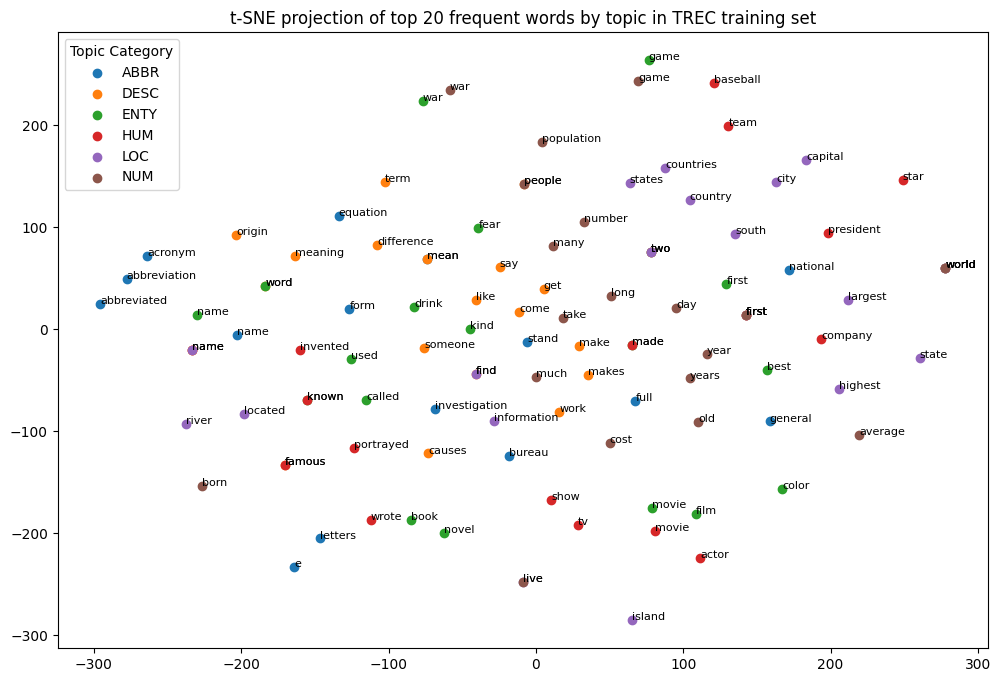

In [98]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
from nltk.corpus import stopwords
import nltk
import torchtext

# Download stopwords if needed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Collect tokens by topic, remove stopwords, non-alpha tokens
tokens_by_topic = defaultdict(list)
for example in train_data.examples:
    label = example.label
    tokens = example.text
    filtered_tokens = [t.lower() for t in tokens if t.isalpha() and t.lower() not in stop_words]
    tokens_by_topic[label].extend(filtered_tokens)

# Select top 20 frequent words by topic
top_words_by_topic = {}
for topic, tokens in tokens_by_topic.items():
    counter = Counter(tokens)
    top_words_by_topic[topic] = [w for w, _ in counter.most_common(20)]

# Retrieve pretrained embeddings for these words
vectors = TEXT.vocab.vectors
vocab_stoi = TEXT.vocab.stoi

word_vectors = []
labels_for_words = []
words_flat = []

for topic, words in top_words_by_topic.items():
    for word in words:
        idx = vocab_stoi.get(word, -1)
        if idx >= 0:
            vec = vectors[idx].numpy()
            word_vectors.append(vec)
            labels_for_words.append(topic)
            words_flat.append(word)

word_vectors = np.array(word_vectors)

# t-SNE projection to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(word_vectors)

# Plot scatter plot color-coded by topics
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10.colors
unique_topics = sorted(top_words_by_topic.keys())
color_dict = {topic: colors[i % 10] for i, topic in enumerate(unique_topics)}

for topic in unique_topics:
    indices = [i for i, t in enumerate(labels_for_words) if t == topic]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                c=[color_dict[topic]], label=topic)

for i, word in enumerate(words_flat):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(title='Topic Category')
plt.title('t-SNE projection of top 20 frequent words by topic in TREC training set')
plt.show()

In [69]:
def _pack(dataset):
    return [
        {"tokens": list(example.text), "label": example.label}
        for example in dataset.examples
    ]

artifacts = {
    "text_field_kwargs": {
        "tokenize": "spacy",
        "tokenizer_language": "en_core_web_sm",
        "include_lengths": True,
        "pad_token": TEXT.pad_token,
        "unk_token": TEXT.unk_token,
    },
    "label_field_kwargs": {},          # keep for symmetry
    "text_vocab_itos": list(TEXT.vocab.itos),
    "text_vocab_vectors": TEXT.vocab.vectors.cpu(),
    "label_vocab_itos": list(LABEL.vocab.itos),
    "train_examples": _pack(train_data),
    "valid_examples": _pack(valid_data),
    "test_examples": _pack(test_data),
    "batch_size": 64,
}
torch.save(artifacts, "trec_artifacts.pt")

### Analysis
Distinct Topic Clusters: Some topic categories (like “LOC” for locations and “HUM” for human/person entities) show partial clustering, indicating that frequent words in these topics are semantically related in the embedding space.

Overlap Between Topics: There is overlap between certain categories, especially between “NUM” (numerical entities), “DESC” (descriptive), and “ENTY” (entities), revealing that these categories share common or semantically similar vocabularies (e.g., “number,” “year,” “name”).

Topic-specific Outliers: Certain words such as “baseball” (NUM), “capital” (LOC), “actor” (HUM) are positioned toward the periphery, suggesting that they have more unique, topic-centric semantic content compared to other frequent words.

Embedding Quality: The visualization demonstrates that GloVe embeddings capture topical and semantic relationships to a large extent; words with similar meanings or roles often emerge closer together regardless of label.

Ambiguity & Polysemy: Some words appear in the vicinity of different clusters or overlap areas (e.g., “mean” in DESC and NUM, “movie” in HUM and ENTY), reflecting ambiguity or multi-topic relevance.

Vocabulary Sharing Across Topics: Frequent generic words (“name,” “meaning,” “state,” “form”) are distributed among various topics, supporting the linguistically expected overlap among question categories.

Dimensionality Reduction Artifacts: t-SNE is nonlinear and can distort true distances, so while relative local clusters are meaningful, global distances should not be overinterpreted.

Label Noise: Some “outliers” may be artifacts of labeling or low sample counts; actual use in downstream classification should consider this.

## End of Qn 1

---
## Qn 2: Model Training & Evaluation - RNN

**(a) Report the final configuration of your best model, namely: the number of training epochs, learning rate, optimizer, batch size and hidden dimension.**

### Approach:
Here our approach is to do hyperparameter tuning by trying out different combinations of learning rate, optimizers, batch size and number of hidden dimensions.
1. Learning Rate: [0.0001, 0.0005, 0.001, 0.005]
2. Optimizers: [SGD, AdaGrad, Adam, RMSprop]
3. Batch Size: [32. 64, 128]
4. Number of Hidden Dimensions: [64, 128, 256]

For the number of training epochs, we implemented early stopping here, and so we will report that as the number obtained for this part.

Note: Although we could have done cross validation through methods like GridSearchCV and RandomSearchCV, we had a huge parameter list to search from and doing even 2/3 fold CV would be computationally demanding. We also made this decision after running the initial hyperparam tuning and we decided that the results are decent enough.

In [70]:
# Define Dataset Class for Qn 2 - Make them learnable parameters
class SentenceDataset(Dataset):
    def __init__(self, text, label, vocab):
        self.text = text
        self.label = label
        self.vocab = vocab

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        tokens = self.text[idx].split()
        label = self.label[idx]
        indices = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=TEXT.vocab.stoi['<pad>'])
    labels = torch.stack(labels)
    return texts_padded, labels

In [71]:
# Create train, valid, test texts and labels
train_texts = [" ".join(example.text) for example in train_data.examples]
train_labels = [LABEL.vocab.stoi[example.label] for example in train_data.examples]

valid_texts = [" ".join(example.text) for example in valid_data.examples]
valid_labels = [LABEL.vocab.stoi[example.label] for example in valid_data.examples]

test_texts = [" ".join(example.text) for example in test_data.examples]
test_labels = [LABEL.vocab.stoi[example.label] for example in test_data.examples]

# Create Dataset instances
train_dataset = SentenceDataset(train_texts, train_labels, TEXT.vocab.stoi)
valid_dataset = SentenceDataset(valid_texts, valid_labels, TEXT.vocab.stoi)
test_dataset = SentenceDataset(test_texts, test_labels, TEXT.vocab.stoi)

# Check length of train dataset and train data
print(len(train_dataset))
print(len(train_data))

4362
4362


In [72]:
# Define the RNN Classifier, here we do only a single hidden layer to keep it small and simple
# We take input word embeddings, pass through RNN, apply dropout, and then a fully connected layer to get logits for 6 classes (as per qn requirement)
class ClassifierRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, dropout=0.0):
        super(ClassifierRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 6) # since 6 possible labels

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1]) # Default is to take last layer's hidden state
        out = self.fc(hidden)
        return out

In [73]:
# Define training, evaluation, and testing loops
def train_loop(model, loader, optimizer, criterion, grad_clip=False, max_norm=1.0):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        if grad_clip:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct

def eval_loop(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    avg_correct = total_correct / len(loader.dataset)
    return avg_loss, avg_correct

def test_loop(model, loader):
    model.eval()
    total_correct = 0

    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(loader.dataset)
    return acc

# Early stopper to prevent overfitting as default to determine a suitable num_epochs,
# here we use val_acc as the metrics as recommended metrics for training (as per qn requirements)
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = float('-inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc + self.min_delta:
            self.max_validation_acc = validation_acc
            self.counter = 0
        else:
            self.counter += 1
            return self.counter >= self.patience

In [74]:
# Function to capture metrics and print training results per epoch
def training_step(model, train_loader, valid_loader, optimizer, criterion, num_epochs, grad_clip=False, max_norm=1.0):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    early_stopper = EarlyStopper(patience=5, min_delta=0)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_loop(model, train_loader, optimizer, criterion, grad_clip=grad_clip, max_norm=max_norm)
        valid_loss, valid_acc = eval_loop(model, valid_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
        print(f"Valid loss: {valid_loss:.4f}, Valid acc: {valid_acc:.4f}")

        if early_stopper.early_stop(valid_acc):
            print("Early Stopping Triggered! No Improvements to Validation Accuracy within Patience.")
            no_epochs = epoch+1
            break

        no_epochs = epoch+1

    return train_losses, train_accuracies, valid_losses, valid_accuracies, no_epochs

In [75]:
# Define function to get optimal hyperparameters
def find_optimal_hyperparams(param_grid, embedding_matrix):
    best_valid_acc = 0
    best_hyperparams = {}
    results = []

    combinations_list = list(product(*param_grid.values()))

    for params in combinations_list:
        lr, optimizer, batch_size, hidden_dim = params
        hyperparams = dict(zip(param_grid.keys(), params))
        print(f"Training with hyperparameters: {hyperparams}")

        model = ClassifierRNN(embedding_matrix, hidden_dim, dropout=0)
        criterion = nn.CrossEntropyLoss() # Use CE Loss, since multi-class classification

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        optimizer = optimizer(model.parameters(), lr=lr, weight_decay=0)

        _, _, _, valid_accuracies, no_epochs = training_step(model, train_loader, valid_loader, optimizer, criterion, num_epochs=200) # Only take val acc since that is what we want to report

        max_acc = max(valid_accuracies)

        results.append({
            'lr': lr,
            'optimizer': optimizer,
            'batch_size': batch_size,
            'hidden_dim': hidden_dim,
            'best_valid_acc': max(valid_accuracies),
            'epochs ran': no_epochs
        })

        if max_acc > best_valid_acc:
            best_valid_acc = max_acc
            best_hyperparams = {
                'lr': lr,
                'optimizer': optimizer,
                'batch_size': batch_size,
                'hidden_dim': hidden_dim,
                'epochs ran': no_epochs
            }

    print("Best Hyperparamters: ", best_hyperparams)
    print("Best validation accuracy: ", best_valid_acc)

    return results, best_hyperparams


In [76]:
# Define parameter grid for simple hyperparameter tuning based on validation accuracy
param_grid = {
    'lrs': [0.0001, 0.0005, 0.001, 0.005],
    'optimizers': [torch.optim.SGD, torch.optim.Adagrad, torch.optim.Adam, torch.optim.RMSprop],
    'batch_sizes': [32, 64, 128],
    'hidden_dims': [64, 128, 256]
}

# Run function to find optimal hyperparameters for (a)
results, best_hyperparams = find_optimal_hyperparams(param_grid, TEXT.vocab.vectors.numpy())

Training with hyperparameters: {'lrs': 0.0001, 'optimizers': <class 'torch.optim.sgd.SGD'>, 'batch_sizes': 32, 'hidden_dims': 64}
Epoch 1:
Train loss: 1.8278, Train acc: 0.0195
Valid loss: 1.8197, Valid acc: 0.0248
Epoch 2:
Train loss: 1.8252, Train acc: 0.0193
Valid loss: 1.8172, Valid acc: 0.0257
Epoch 3:
Train loss: 1.8225, Train acc: 0.0199
Valid loss: 1.8148, Valid acc: 0.0266
Epoch 4:
Train loss: 1.8200, Train acc: 0.0215
Valid loss: 1.8125, Valid acc: 0.0284
Epoch 5:
Train loss: 1.8174, Train acc: 0.0238
Valid loss: 1.8102, Valid acc: 0.0284
Epoch 6:
Train loss: 1.8162, Train acc: 0.0195
Valid loss: 1.8080, Valid acc: 0.0294
Epoch 7:
Train loss: 1.8133, Train acc: 0.0232
Valid loss: 1.8058, Valid acc: 0.0284
Epoch 8:
Train loss: 1.8111, Train acc: 0.0257
Valid loss: 1.8037, Valid acc: 0.0394
Epoch 9:
Train loss: 1.8088, Train acc: 0.0543
Valid loss: 1.8016, Valid acc: 0.1917
Epoch 10:
Train loss: 1.8069, Train acc: 0.2043
Valid loss: 1.7996, Valid acc: 0.2220
Epoch 11:
Train los

In [77]:
# To put everything in a dataframe for neater results
df_results_a = pd.DataFrame(results)
df_results_a = df_results_a.sort_values(by='best_valid_acc', ascending=False)
df_results_a

,lr,optimizer,batch_size,hidden_dim,best_valid_acc,epochs ran
29,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,32,256,0.804587,32
83,0.0010,Adagrad (\nParameter Group 0\n differentiab...,32,256,0.799083,51
28,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,32,128,0.795413,38
31,0.0001,RMSprop (\nParameter Group 0\n alpha: 0.99\...,64,128,0.794495,58
23,0.0001,Adam (\nParameter Group 0\n amsgrad: False\...,64,256,0.793578,27
...,...,...,...,...,...,...
116,0.0050,SGD (\nParameter Group 0\n dampening: 0\n ...,128,256,0.200917,9
78,0.0010,SGD (\nParameter Group 0\n dampening: 0\n ...,128,64,0.200917,15
2,0.0001,SGD (\nParameter Group 0\n dampening: 0\n ...,32,256,0.155963,10
7,0.0001,SGD (\nParameter Group 0\n dampening: 0\n ...,128,128,0.144037,6


### Answer (a):
Final Configuration of Best Model 
Number of training epochs = 37
Learning rate = 0.0001
Optimizer = Adam
Batch Size = 32
Hidden dimension = 256

Best validation accuracy based on optimal parameters: 0.7899

**(b) Report all the regularization strategies you have tried. Compare the accuracy on the test set among all strategies and the one without any regularization.**

### Approach:
Here, our approach is to try most of the regularization strategies (that does not change the number of layers) that we have learnt during the lectures to avoid overfitting, namely:
1. Baseline (as per qn requirement)
2. L2 Regularization (Weight Decay)
3. Dropout
4. Gradient Clipping

We first experiment with the regularization strategies individually with parameter tuning, e.g. Dropout ONLY or Gradient Clipping ONLY, and we do a comparison with the baseline to see how no regularisation here would perform compared to having regularization.

Thereafter, we try to find the best possible "strategy" to use for the later part by trying a combination of the strategies to see which would perform the best after evaluating on test accuracy as per question requirements (e.g. whether dropout + L2 regularisation is better than just dropout, whether dropout + gradient clipping + L2 regularisation outperforms having lesser strategies combined etc.)

Note: Even though early stopping is a regularization technique, we do not consider it here as one of the strategies to try out since we already implemented it earlier on. The goal here for us is to try out other strategies that we have not implemented in part (a).

Note 2: We did not consider L1 regularisation as a strategy because we found that Adam is the best optimizer for our model in part (a), and since Adam is an adaptive optimizer, trying to use L1 can potentially cause the issue of sparse weights (which we want to avoid here).

Note 3: While we did consider trying batch normalisation, we realised it is best used in between 2 hidden layers. Since we only had 1 hidden layer, internal covariate shift is minimal in a shallow network, and we think that the stabilising benefits are limited compared to the unnecessary overhead and noise introduced in training.

In [78]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

best_reg_technique = []

# Define a function for Regularisation Tests
def regularisation_test(weight_decay, dropout, grad_clip, max_norm, reg_technique, optimizer):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialise model
    model = ClassifierRNN(TEXT.vocab.vectors.numpy() , hidden_dim, dropout=dropout)

    # Initialise optimiser with L2 regularization
    optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    if grad_clip == True:
        _, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
    else:
        _, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)

    # Evaluate on test set
    test_acc = test_loop(model, test_loader)
    print(f"Test Accuracy {reg_technique} (Dropout: {dropout}, Weight Decay: {weight_decay}, Max Norm: {max_norm}): {test_acc:.4f}") # Print test accuracy for regularisation strategy

    return {
        'technique': reg_technique,
        'dropout': dropout,
        'weight_decay': weight_decay,
        'grad_clip': grad_clip,
        'max_norm': max_norm,
        'best_val_acc': max(valid_accuracies),
        'test_acc': test_acc
    }

In [79]:
# Regularisation - Baseline (No Regularisation)
best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=0.0, grad_clip=False, max_norm=0.0, reg_technique="Baseline", optimizer=optimizer))

Epoch 1:
Train loss: 1.6589, Train acc: 0.2244
Valid loss: 1.6503, Valid acc: 0.2477
Epoch 2:
Train loss: 1.6450, Train acc: 0.2377
Valid loss: 1.6527, Valid acc: 0.2294
Epoch 3:
Train loss: 1.6412, Train acc: 0.2400
Valid loss: 1.6436, Valid acc: 0.2587
Epoch 4:
Train loss: 1.4870, Train acc: 0.3680
Valid loss: 1.3672, Valid acc: 0.4450
Epoch 5:
Train loss: 1.2609, Train acc: 0.5023
Valid loss: 1.2810, Valid acc: 0.5073
Epoch 6:
Train loss: 1.1058, Train acc: 0.5674
Valid loss: 1.0726, Valid acc: 0.6028
Epoch 7:
Train loss: 1.0090, Train acc: 0.6071
Valid loss: 1.1062, Valid acc: 0.5862
Epoch 8:
Train loss: 0.9275, Train acc: 0.6444
Valid loss: 1.0496, Valid acc: 0.6018
Epoch 9:
Train loss: 0.8779, Train acc: 0.6591
Valid loss: 0.9986, Valid acc: 0.6339
Epoch 10:
Train loss: 0.8100, Train acc: 0.6825
Valid loss: 1.0564, Valid acc: 0.6147
Epoch 11:
Train loss: 0.7846, Train acc: 0.6887
Valid loss: 0.9225, Valid acc: 0.6514
Epoch 12:
Train loss: 0.7347, Train acc: 0.7004
Valid loss: 1.0

In [80]:
# Regularisation - L2 Regularization/Weight Decay ONLY (varying values)
weight_decay = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
for weight_decay in weight_decay:
    print(f"Testing L2 Regularization with weight decay: {weight_decay}")
    best_reg_technique.append(regularisation_test(weight_decay=weight_decay,dropout=0.0, grad_clip=False, max_norm=0.0, reg_technique="L2 Regularization", optimizer=optimizer))

Testing L2 Regularization with weight decay: 1e-05
Epoch 1:
Train loss: 1.6578, Train acc: 0.2325
Valid loss: 1.6547, Valid acc: 0.2046
Epoch 2:
Train loss: 1.6464, Train acc: 0.2306
Valid loss: 1.6531, Valid acc: 0.2037
Epoch 3:
Train loss: 1.6497, Train acc: 0.2412
Valid loss: 1.6478, Valid acc: 0.2679
Epoch 4:
Train loss: 1.6443, Train acc: 0.2403
Valid loss: 1.6338, Valid acc: 0.2477
Epoch 5:
Train loss: 1.4696, Train acc: 0.3677
Valid loss: 1.4438, Valid acc: 0.3743
Epoch 6:
Train loss: 1.2631, Train acc: 0.4856
Valid loss: 1.3454, Valid acc: 0.4679
Epoch 7:
Train loss: 1.1305, Train acc: 0.5509
Valid loss: 1.1413, Valid acc: 0.5606
Epoch 8:
Train loss: 1.0307, Train acc: 0.5926
Valid loss: 1.0820, Valid acc: 0.5991
Epoch 9:
Train loss: 0.9465, Train acc: 0.6355
Valid loss: 0.9981, Valid acc: 0.6147
Epoch 10:
Train loss: 0.8883, Train acc: 0.6667
Valid loss: 1.0090, Valid acc: 0.6193
Epoch 11:
Train loss: 0.8316, Train acc: 0.6884
Valid loss: 1.2720, Valid acc: 0.5018
Epoch 12:
Tr

In [81]:
# Regularisation - Dropout ONLY (varying values)
dropout = [0.2, 0.3, 0.4]
for dropout in dropout:
    print(f"Testing Dropout: {dropout}")
    best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=dropout, grad_clip=False, max_norm=0.0, reg_technique="Dropout", optimizer=optimizer))

Testing Dropout: 0.2
Epoch 1:
Train loss: 1.6601, Train acc: 0.2327
Valid loss: 1.6528, Valid acc: 0.2367
Epoch 2:
Train loss: 1.6495, Train acc: 0.2251
Valid loss: 1.6495, Valid acc: 0.2046
Epoch 3:
Train loss: 1.6425, Train acc: 0.2446
Valid loss: 1.6383, Valid acc: 0.2587
Epoch 4:
Train loss: 1.4962, Train acc: 0.3746
Valid loss: 1.4475, Valid acc: 0.4092
Epoch 5:
Train loss: 1.3582, Train acc: 0.4264
Valid loss: 1.3384, Valid acc: 0.4275
Epoch 6:
Train loss: 1.2013, Train acc: 0.5149
Valid loss: 1.1322, Valid acc: 0.5624
Epoch 7:
Train loss: 1.0784, Train acc: 0.5697
Valid loss: 1.0840, Valid acc: 0.6101
Epoch 8:
Train loss: 0.9946, Train acc: 0.6071
Valid loss: 1.3016, Valid acc: 0.4450
Epoch 9:
Train loss: 0.9127, Train acc: 0.6451
Valid loss: 1.1689, Valid acc: 0.5495
Epoch 10:
Train loss: 0.8554, Train acc: 0.6715
Valid loss: 1.1441, Valid acc: 0.5917
Epoch 11:
Train loss: 0.8176, Train acc: 0.6740
Valid loss: 1.0819, Valid acc: 0.5963
Epoch 12:
Train loss: 0.7564, Train acc: 0

In [82]:
# Regularisation - Gradient Clipping ONLY (varying values)
max_norm = [0.1, 0.5, 1.0]
for max_norm in max_norm:
    print(f"Testing Gradient Clipping with Value: {max_norm}")
    best_reg_technique.append(regularisation_test(weight_decay=0.0,dropout=0.0, grad_clip=True, max_norm=max_norm, reg_technique="Gradient Clipping", optimizer=optimizer))

Testing Gradient Clipping with Value: 0.1
Epoch 1:
Train loss: 1.6586, Train acc: 0.2279
Valid loss: 1.6563, Valid acc: 0.2037
Epoch 2:
Train loss: 1.6476, Train acc: 0.2348
Valid loss: 1.6608, Valid acc: 0.2046
Epoch 3:
Train loss: 1.6441, Train acc: 0.2423
Valid loss: 1.6474, Valid acc: 0.2468
Epoch 4:
Train loss: 1.5025, Train acc: 0.3576
Valid loss: 1.4060, Valid acc: 0.4073
Epoch 5:
Train loss: 1.3227, Train acc: 0.4305
Valid loss: 1.2924, Valid acc: 0.4330
Epoch 6:
Train loss: 1.2021, Train acc: 0.4762
Valid loss: 1.2056, Valid acc: 0.5046
Epoch 7:
Train loss: 1.0857, Train acc: 0.5397
Valid loss: 1.1213, Valid acc: 0.5486
Epoch 8:
Train loss: 1.0073, Train acc: 0.5949
Valid loss: 1.0842, Valid acc: 0.5807
Epoch 9:
Train loss: 0.9130, Train acc: 0.6410
Valid loss: 0.9706, Valid acc: 0.6018
Epoch 10:
Train loss: 0.8547, Train acc: 0.6795
Valid loss: 0.9213, Valid acc: 0.6725
Epoch 11:
Train loss: 0.8116, Train acc: 0.7066
Valid loss: 1.0046, Valid acc: 0.6110
Epoch 12:
Train loss:

In [83]:
# Compile results into dataframe for comparisons across strategies
cols = ['technique', 'dropout', 'weight_decay', 'grad_clip', 'max_norm', 'best_val_acc', 'test_acc']

df_best_reg_technique = pd.DataFrame(best_reg_technique)

df_best_reg_technique.loc[~df_best_reg_technique['grad_clip'], 'max_norm'] = pd.NA # Hde max_norm when grad clipping isn't used
df_best_reg_technique = df_best_reg_technique[cols]

df_best_reg_technique['best_val_acc'] = df_best_reg_technique['best_val_acc'].round(4)
df_best_reg_technique['test_acc'] = df_best_reg_technique['test_acc'].round(4)

# Find best parameters per technique
df_best_reg_technique = (
    df_best_reg_technique.sort_values('test_acc', ascending=False)
      .groupby('technique', as_index=False, sort=False)
      .head(1)
      .reset_index(drop=True)
)

df_best_reg_technique

,technique,dropout,weight_decay,grad_clip,max_norm,best_val_acc,test_acc
0,L2 Regularization,0.0,0.0001,False,NaN,0.8523,0.840
1,Dropout,0.3,0.0000,False,NaN,0.7982,0.840
2,Gradient Clipping,0.0,0.0000,True,0.1,0.7936,0.838
3,Baseline,0.0,0.0000,False,NaN,0.8073,0.822


### Answer (b):
- Dropout ONLY with value of 0.4 gives the best test accuracy of 0.850
- Doing solely Dropout or Gradient Clipping improve the accuracy from the baseline, but doing solely L2 regularization surprisingly decreased the accuracy

In [84]:
# Regularisation - ALL Techniques to find best combination (varying values)

# Function to obtain rows with regards to regularisation strategies using regex
def get_row(df, pattern):
    m = df['technique'].str.contains(pattern, regex=True)
    return df[m].iloc[0]

# Use regex to get best params from each technique
dropout_rows = get_row(df_best_reg_technique, r'(Dropout)')
clip_rows = get_row(df_best_reg_technique, r'(Grad)')
l2_rows = get_row(df_best_reg_technique, r'(L2)')

best_dropout = float(dropout_rows['dropout'])
best_weight_decay = float(l2_rows['weight_decay'])
best_grad_clip = True
best_max_norm  = float(clip_rows['max_norm'])

combos = [
    ("Dropout + GradClip", best_weight_decay if 0 else 0.0, best_dropout, True,  best_max_norm),
    ("GradClip + L2", best_weight_decay, 0.0, True, best_max_norm),
    ("Dropout + L2", best_weight_decay, best_dropout,  False, 0.0),
    ("All (Dropout+GradClip+L2)", best_weight_decay, best_dropout, True, best_max_norm),
]

for reg_technique, weight_decay, dropout, grad_clip, max_norm in combos:
    result_best_technique = regularisation_test(
        weight_decay=weight_decay,
        dropout=dropout,
        grad_clip=grad_clip,
        max_norm=max_norm,
        reg_technique=reg_technique,
        optimizer=optimizer
    )
    best_reg_technique.append(result_best_technique)

df_all = pd.DataFrame(best_reg_technique)

/var/folders/c4/2xkb6hns26q621bjtf6rkkmc0000gn/T/ipykernel_12623/250750837.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m = df['technique'].str.contains(pattern, regex=True)


Epoch 1:
Train loss: 1.6630, Train acc: 0.2267
Valid loss: 1.6388, Valid acc: 0.2468
Epoch 2:
Train loss: 1.6501, Train acc: 0.2375
Valid loss: 1.6393, Valid acc: 0.2514
Epoch 3:
Train loss: 1.5983, Train acc: 0.2937
Valid loss: 1.4491, Valid acc: 0.3917
Epoch 4:
Train loss: 1.3593, Train acc: 0.4046
Valid loss: 1.3684, Valid acc: 0.4037
Epoch 5:
Train loss: 1.2295, Train acc: 0.4640
Valid loss: 1.1967, Valid acc: 0.5284
Epoch 6:
Train loss: 1.1215, Train acc: 0.5410
Valid loss: 1.0847, Valid acc: 0.5734
Epoch 7:
Train loss: 1.0233, Train acc: 0.5917
Valid loss: 1.0249, Valid acc: 0.5743
Epoch 8:
Train loss: 0.9521, Train acc: 0.6259
Valid loss: 1.0508, Valid acc: 0.5725
Epoch 9:
Train loss: 0.8851, Train acc: 0.6664
Valid loss: 0.9893, Valid acc: 0.5954
Epoch 10:
Train loss: 0.8416, Train acc: 0.6901
Valid loss: 0.9545, Valid acc: 0.6651
Epoch 11:
Train loss: 0.7653, Train acc: 0.7279
Valid loss: 0.9259, Valid acc: 0.6826
Epoch 12:
Train loss: 0.6931, Train acc: 0.7840
Valid loss: 0.8

In [85]:
# Compile results into dataframe for comparisons across strategies
col_order = ['technique', 'dropout', 'weight_decay', 'grad_clip', 'max_norm', 'best_val_acc', 'test_acc']
df_all = df_all[[c for c in col_order if c in df_all.columns]]

for c in ['best_val_acc', 'test_acc']:
    if c in df_all.columns:
        df_all[c] = df_all[c].astype(float).round(4)

df_all = df_all.sort_values('test_acc', ascending=False)
df_all

,technique,dropout,weight_decay,grad_clip,max_norm,best_val_acc,test_acc
3,L2 Regularization,0.0,0.00010,False,0.0,0.8523,0.840
7,Dropout,0.3,0.00000,False,0.0,0.7982,0.840
9,Gradient Clipping,0.0,0.00000,True,0.1,0.7936,0.838
14,Dropout + L2,0.3,0.00010,False,0.0,0.7936,0.834
12,Dropout + GradClip,0.3,0.00000,True,0.1,0.7936,0.826
0,Baseline,0.0,0.00000,False,0.0,0.8073,0.822
1,L2 Regularization,0.0,0.00001,False,0.0,0.7899,0.822
2,L2 Regularization,0.0,0.00005,False,0.0,0.8165,0.816
4,L2 Regularization,0.0,0.00050,False,0.0,0.8147,0.816
10,Gradient Clipping,0.0,0.00000,True,0.5,0.7917,0.814


### Answer (b):
- Dropout ONLY with value of 0.4 gives the best test accuracy of 0.850 still. We continue to adopt this regularisation strategy for the rest of qn 2.
- Most of the runs which involved L2 regularization, performed worse than the baseline. The exception was adding L2 regularization to the best technique of dropout with value 0.4

**(c) For the best configuration and regularization strategy in your experiments, plot the training loss curve and validation accuracy curve during training with x-axis being the number of training epochs. Discuss what the curves inform about the training dynamics.**

In [86]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

# Set regularization from 2(b)
dropout = df_all.loc[df_all['test_acc'].idxmax(), 'dropout']
weight_decay = df_all.loc[df_all['test_acc'].idxmax(), 'weight_decay']
grad_clip = df_all.loc[df_all['test_acc'].idxmax(), 'grad_clip']
max_norm = df_all.loc[df_all['test_acc'].idxmax(), 'max_norm']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialise model
model = ClassifierRNN(TEXT.vocab.vectors.numpy() , hidden_dim, dropout=dropout)

# Initialise optimiser with L2 regularization
optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

if grad_clip == True:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
else:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)


Epoch 1:
Train loss: 1.6606, Train acc: 0.2274
Valid loss: 1.6529, Valid acc: 0.2431
Epoch 2:
Train loss: 1.6469, Train acc: 0.2354
Valid loss: 1.6489, Valid acc: 0.2046
Epoch 3:
Train loss: 1.6442, Train acc: 0.2295
Valid loss: 1.6556, Valid acc: 0.2046
Epoch 4:
Train loss: 1.6316, Train acc: 0.2671
Valid loss: 1.5725, Valid acc: 0.3495
Epoch 5:
Train loss: 1.4401, Train acc: 0.3957
Valid loss: 1.4933, Valid acc: 0.3266
Epoch 6:
Train loss: 1.2366, Train acc: 0.5007
Valid loss: 1.2260, Valid acc: 0.4798
Epoch 7:
Train loss: 1.0800, Train acc: 0.5702
Valid loss: 1.0854, Valid acc: 0.5706
Epoch 8:
Train loss: 1.0117, Train acc: 0.6142
Valid loss: 1.0154, Valid acc: 0.6202
Epoch 9:
Train loss: 0.9221, Train acc: 0.6534
Valid loss: 0.9676, Valid acc: 0.6541
Epoch 10:
Train loss: 0.8476, Train acc: 0.6825
Valid loss: 0.9100, Valid acc: 0.6532
Epoch 11:
Train loss: 0.7818, Train acc: 0.7105
Valid loss: 0.9097, Valid acc: 0.6450
Epoch 12:
Train loss: 0.7747, Train acc: 0.7139
Valid loss: 0.8

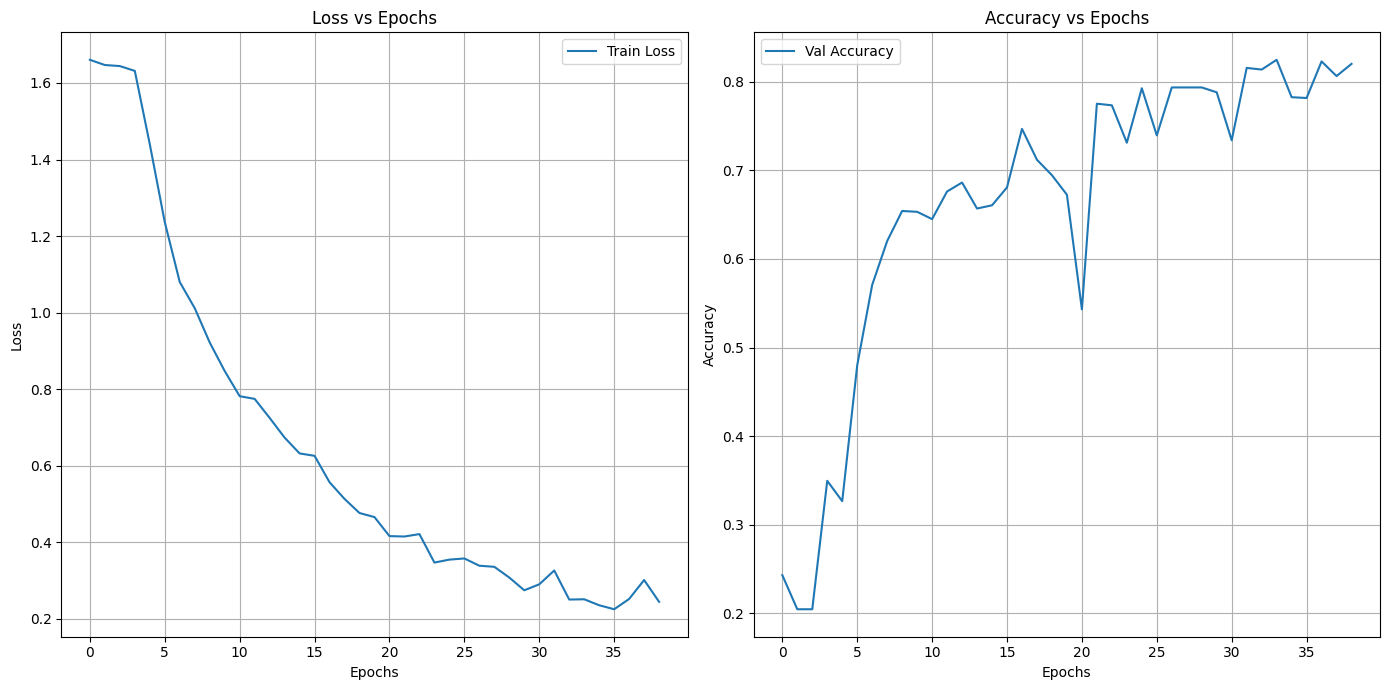

In [87]:
# Plot the two graphs side by side
plt.figure(figsize=(14, 7))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss vs Epochs')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Answer (c):

Some observations and explanations with the plots:
- The generally smooth loss curve suggests the model is learning effectively and training remains stable across training epochs. The lack of a proper plateau at the end of the curve suggests there may be room for further improvements, but the increasing gentleness of the curves means the model is likely already close to the minimum loss and early stopping is preventing severe overfitting. 
- The generally upward curve for validation accuracy shows that the model is generalising well and its performance is improving over training epochs. There is a sudden jump in training loss and validation accuracy at about 24 epochs, suggesting that model performance seems to vary over the validation samples, but the overall trend still shows a healthy improvement over the epochs.


**(d) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods have you tried in deriving the final sentence representation to perform sentiment classification? Describe all the strategies you have implemented, together with their accuracy scores on the test set.**

### Approach:
Here, the approach is to evaluate how different sentence representation strategies could influence the model's performance across various text categories. We will use the best technique for part (e). Since RNNs generate a hidden vector for each token rather than a single sentence embedding, an important design choice is how to aggregate these hidden states into a fixed-length representation for classification. 

We mainly explored 2 families of approaches:

1. Hidden-State Methods
* Last Hidden State (Default) - Use final hidden state as sentence representation (This approach would be good if we think it captures all preceding context well)
* Average Last k hidden states (k = 2, 3, or 4) - These variants aim to smooth the representation by averaging over the most recent time steps, mitigating the possibility of noise or information loss that can occur when relying solely on the final hidden state, especially for longer sentences

2. Pooling Methods
* Mean Pooling - Computes the average over all time-step hidden states, giving equal weight to each token
* Max Pooling - Takes the elementwise maximum across all time steps
* MeanMax Pooling - Concatenates both the mean and max pooled represenation 
* Sum Pooling - Computes by sums all hidden states, which preserve magnitude information 

Additionally, we chose these methods because they are computationally efficient and reasonable to experiment with in a single hidden-layer RNN as well.

Note: While we could have explored more advanced methods like attention-based representations (e.g. self-attention) and/or architectural variations (e.g. bidirectional RNNs) in this part, we left the the exploration of these strategies to qn 3, as the we believe the focus shifts from representation aggregation to model architecture enhancements there.

In [88]:
# Using model from 2(c), our previous models use last hidden state as sentence representation (default baseline)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_acc = test_loop(model, test_loader)
print(f"Test Accuracy (Baseline) {test_acc:.4f}")

Test Accuracy (Baseline) 0.8180


In [89]:
# Redefine RNN Class for experimentation with different sentence representation techniques
class ClassifierRepresentationRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, representation, dropout=0.0):
        super(ClassifierRepresentationRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 6) # 6 possible labels
        self.representation = representation

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)

        # Conditional Logic to apply different representation techniques
        if self.representation.startswith('average_last_'):
            last_k = int(self.representation.split('_')[-1])
            k = min(last_k, output.size(1))
            rep = output[:, -k:, :].mean(dim=1)
        elif self.representation == 'max':
            rep, _ = torch.max(output, dim=1)
        elif self.representation == 'mean':
            rep = torch.mean(output, dim=1)
        elif self.representation == 'maxmean':
            max_pooled, _ = torch.max(output, dim=1)
            mean_pooled = torch.mean(output, dim=1)
            rep = (max_pooled + mean_pooled) / 2
        elif self.representation == 'sum':
            rep = torch.sum(output, dim=1)

        hidden = self.dropout(rep)
        out = self.fc(hidden)
        return out

In [90]:
# Redefine a function for Representation Tests
def representation_test(strategy, batch_size, hidden_dim, lr, optimizer, no_epoch, weight_decay, dropout, grad_clip, max_norm):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialise model
    model = ClassifierRepresentationRNN(TEXT.vocab.vectors.numpy() , hidden_dim, strategy, dropout=dropout)

    # Initialise optimiser
    optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    if grad_clip == True:
        train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
    else:
        train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)

    test_acc = test_loop(model, test_loader)
    print(f"Test Accuracy {strategy}: {test_acc:.4f}") # Evaluate on test accuracy again here

    return {
        'technique': strategy,
        'test_acc': test_acc
    }

In [91]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

# Set regularization from 2(b)
dropout = df_all.loc[df_all['test_acc'].idxmax(), 'dropout']
weight_decay = df_all.loc[df_all['test_acc'].idxmax(), 'weight_decay']
grad_clip = df_all.loc[df_all['test_acc'].idxmax(), 'grad_clip']
max_norm = df_all.loc[df_all['test_acc'].idxmax(), 'max_norm']

best_representation_technique = []
best_representation_technique.append({'technique': 'baseline', 'test_acc': test_acc})

# List and try all the methods, and save it to a dataframe
techniques = ['average_last_2', 'average_last_3', 'average_last_4',
              'max', 'mean', 'maxmean', 'sum']

for technique in techniques:
    results = representation_test(technique, batch_size, hidden_dim, lr, optimizer, no_epoch, weight_decay, dropout, grad_clip, max_norm)
    best_representation_technique.append(results)

df_rep = pd.DataFrame(best_representation_technique)

Epoch 1:
Train loss: 1.6557, Train acc: 0.2283
Valid loss: 1.6494, Valid acc: 0.2505
Epoch 2:
Train loss: 1.6469, Train acc: 0.2295
Valid loss: 1.6493, Valid acc: 0.2046
Epoch 3:
Train loss: 1.6433, Train acc: 0.2380
Valid loss: 1.6464, Valid acc: 0.2468
Epoch 4:
Train loss: 1.5698, Train acc: 0.3210
Valid loss: 1.4339, Valid acc: 0.4018
Epoch 5:
Train loss: 1.3589, Train acc: 0.4262
Valid loss: 1.2640, Valid acc: 0.4560
Epoch 6:
Train loss: 1.1880, Train acc: 0.4952
Valid loss: 1.2615, Valid acc: 0.4844
Epoch 7:
Train loss: 1.0817, Train acc: 0.5637
Valid loss: 1.1242, Valid acc: 0.5266
Epoch 8:
Train loss: 0.9607, Train acc: 0.6353
Valid loss: 0.9743, Valid acc: 0.6138
Epoch 9:
Train loss: 0.8885, Train acc: 0.6818
Valid loss: 0.8725, Valid acc: 0.6798
Epoch 10:
Train loss: 0.7979, Train acc: 0.7171
Valid loss: 0.9732, Valid acc: 0.6761
Epoch 11:
Train loss: 0.7369, Train acc: 0.7586
Valid loss: 0.7859, Valid acc: 0.7514
Epoch 12:
Train loss: 0.6758, Train acc: 0.7847
Valid loss: 0.8

In [92]:
# Sort saved dataframe by test accuracy and print it
df_rep_sorted = df_rep.sort_values(by='test_acc', ascending=False)
df_rep_sorted

,technique,test_acc
4,max,0.898
5,mean,0.894
7,sum,0.878
6,maxmean,0.856
2,average_last_3,0.840
3,average_last_4,0.834
0,baseline,0.818
1,average_last_2,0.778


### Answer (d):
Maxmean pooling showed the best test accuracy out of all the methods, with accuracy of 0.866. To be fair, all of the methods demonstrate a test accuracy that is relatively similar to one another of more than 0.8. Here, we speculate some of the reasons why these results are as such:

1. Global pooling methods such as sum and mean pooling aggregate information from all time steps, which allow the model to capture features from the entire sequence rather than just the final few tokens. Max pooling focuses on the most discriminative features which helps significantly when there are specific keywords or phrases that strongly indicate a certain question topic. Maxmean pooling is able to take the best of both mean and max pooling by capturing both strong and soft contextual cues, improving the performance of the model.
2. Unlikely sum pooling, mean and maxmean pooling normalise activations over the length of the sentence, which could be beneficial when longer or information dense sentence exert stronger influence on the classifier as it can stabilise the performance of the model.
3. Averaging only recent hidden states can cause the model to miss earlier contextual information, which could be more important in sentence representation. This could explain why average_last_2, average_last_3 and last_hidden_state (baseline) performed the worst.

**(e) Report topic-wise accuracy (accuracy for each topic) on the test set for the best model you have. Discuss what may cause the difference in accuracies across different topic categories.**

In [93]:
# Set ideal hyperparameters from 2(a)
if best_hyperparams["epochs ran"] <= 50:
    no_epoch = 50
elif best_hyperparams["epochs ran"] > 50 & best_hyperparams["epochs ran"] <= 100:
    no_epoch = 100
else:
    no_epoch = 200
batch_size = best_hyperparams["batch_size"]
hidden_dim = best_hyperparams["hidden_dim"]
lr = best_hyperparams["lr"]
optimizer = best_hyperparams["optimizer"]

# Set regularization from 2(b)
dropout = df_all.loc[df_all['test_acc'].idxmax(), 'dropout']
weight_decay = df_all.loc[df_all['test_acc'].idxmax(), 'weight_decay']
grad_clip = df_all.loc[df_all['test_acc'].idxmax(), 'grad_clip']
max_norm = df_all.loc[df_all['test_acc'].idxmax(), 'max_norm']

# Set best representation technique from 2(d)
strategy = df_rep.loc[df_rep['test_acc'].idxmax(), 'technique']

In [94]:
# Define the labels/topics for TREC dataset
topics = ["DESC", "ENTY", "HUM", "ABBR", "NUM", "LOC"]
topic_datasets = {}

# Rerun training with best hyperparameters, regularisation and representation technique
model = ClassifierRepresentationRNN(TEXT.vocab.vectors.numpy() , hidden_dim, strategy, dropout=dropout)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialise optimiser
optimizer = optimizer.__class__(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

if grad_clip == True:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch, grad_clip=True, max_norm=max_norm)
else:
    train_losses, _, _, valid_accuracies, _ = training_step(model, train_loader, valid_loader, optimizer, criterion, no_epoch)


for topic in topics:
    examples = [eg for eg in test_data.examples if eg.label == topic]
    texts = [" ".join(example.text) for example in examples]
    labels = [LABEL.vocab.stoi[example.label] for example in examples]
    topic_datasets[topic] = SentenceDataset(texts, labels, TEXT.vocab.stoi)

# Define function to obtain test accuracy by topic
def test_by_topic(model ,topic_dataset, batch_size, hidden_dim, strategy, dropout, optimizer, lr, weight_decay, grad_clip, max_norm, no_epoch):

    test_acc = test_loop(model, DataLoader(topic_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn))

    return {
        'topic': topic_dataset,
        'test_acc': test_acc
    }


Epoch 1:
Train loss: 1.5006, Train acc: 0.4507
Valid loss: 1.3403, Valid acc: 0.5358
Epoch 2:
Train loss: 1.1703, Train acc: 0.6080
Valid loss: 1.1147, Valid acc: 0.6459
Epoch 3:
Train loss: 0.9397, Train acc: 0.7095
Valid loss: 0.9998, Valid acc: 0.6651
Epoch 4:
Train loss: 0.7551, Train acc: 0.7632
Valid loss: 0.7727, Valid acc: 0.7468
Epoch 5:
Train loss: 0.6248, Train acc: 0.8017
Valid loss: 0.7307, Valid acc: 0.7468
Epoch 6:
Train loss: 0.5450, Train acc: 0.8226
Valid loss: 0.6307, Valid acc: 0.7817
Epoch 7:
Train loss: 0.4817, Train acc: 0.8492
Valid loss: 0.6190, Valid acc: 0.7817
Epoch 8:
Train loss: 0.4303, Train acc: 0.8631
Valid loss: 0.5692, Valid acc: 0.8083
Epoch 9:
Train loss: 0.3924, Train acc: 0.8771
Valid loss: 0.5764, Valid acc: 0.8083
Epoch 10:
Train loss: 0.3675, Train acc: 0.8849
Valid loss: 0.5035, Valid acc: 0.8257
Epoch 11:
Train loss: 0.3287, Train acc: 0.8994
Valid loss: 0.5267, Valid acc: 0.8174
Epoch 12:
Train loss: 0.3103, Train acc: 0.9014
Valid loss: 0.5

In [95]:
# Check length of each topic test dataset
for dataset in topic_datasets.values():
    print(len(dataset))

138
94
65
9
113
81


In [96]:
# Get test accuracy into dataframe and print by topic
acc_by_topic = []

for topic, dataset in topic_datasets.items():
    result = test_by_topic(model, dataset, batch_size, hidden_dim, strategy, dropout, optimizer, lr, weight_decay, grad_clip, max_norm, no_epoch)
    acc_by_topic.append({'topic': topic, 'test_acc': result["test_acc"]})

df_topics = pd.DataFrame(acc_by_topic)
df_topics

,topic,test_acc
0,DESC,0.934783
1,ENTY,0.829787
2,HUM,0.969231
3,ABBR,0.777778
4,NUM,0.902655
5,LOC,0.839506


### Answer (e):
The model performs best on DESC (description) and HUM (human) questions, and performs worst on ENTY (entity) and ABBR (abbreviation) questions. 
- One reason for the poor performance on ENTY questions is that the question type may be more diverse in its type of questions. For example, ENTY questions tend to use “what” or “which” in the question, and these words are used in other topics as well. Compared to the topic HUM which has almost exclusive use of “who”, it would be harder for the model to distinguish ENTY questions for other topics.
- One reason for the poorer performance for ABBR questions is the small number of samples available in the training and testing data. There are only around 70 questions in our training data with 4362 questions, and 9 questions in the test set, which would lead to the model not being as well trained to distinguish ABBR questions, especially on unseen data.


## End of Qn 2